## 打开LIF文件

在处理显微镜图像数据时，存在许多文件格式，如徕卡图像格式（LIF）。在本笔记本中，我们将使用[`readlif`库](https://pypi.org/project/readlif/)打开一个`.lif`文件。

注意：建议使用[AICSImageIO](https://github.com/AllenCellModeling/aicsimageio)来读取LIF图像，如[本笔记本](image_file_formats:aicsimagio)所示。

`readlif`库可以通过以下方式在终端中安装：

```
pip install readlif
```

安装完成后，就可以导入它了。

In [1]:
from readlif.reader import LifFile

import os
import requests
from skimage.io import imshow
import numpy as np

作为示例数据集，我们将使用由[Gregory Marquart和Harold Burgess](https://zenodo.org/record/3382102#.Y57rFnbMJaQ)在[CC-BY 4.0许可](https://creativecommons.org/licenses/by/4.0/legalcode)下共享的图像。我们首先需要下载它。

In [2]:
filename = "../../data/y293-Gal4_vmat-GFP-f01.lif"
url = 'https://zenodo.org/record/3382102/files/y293-Gal4_vmat-GFP-f01.lif?download=1'

if not os.path.isfile(filename):
    # only download the file if we don't have it yet
    response = requests.get(url)
    open(filename, "wb").write(response.content)

此时，文件应该已经在我们的计算机上，可以像这样打开。

In [3]:
file = LifFile(filename)
file

'LifFile object with 1 image'

In [4]:
lif_image = file.get_image(0)
lif_image

'LifImage object with dimensions: Dims(x=616, y=500, z=86, t=1, m=1)'

从LifImage中，我们可以获取单个帧作为[PIL](https://pypi.org/project/PIL/)图像。

In [5]:
pil_image = lif_image.get_frame(z=0)
type(pil_image)

PIL.Image.Image

最后，这些2D PIL图像可以转换为numpy数组。这最终允许我们查看图像。

In [6]:
np_image = np.array(pil_image)
np_image.shape

(500, 616)

/opt/miniconda3/envs/devbio-napari-env/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


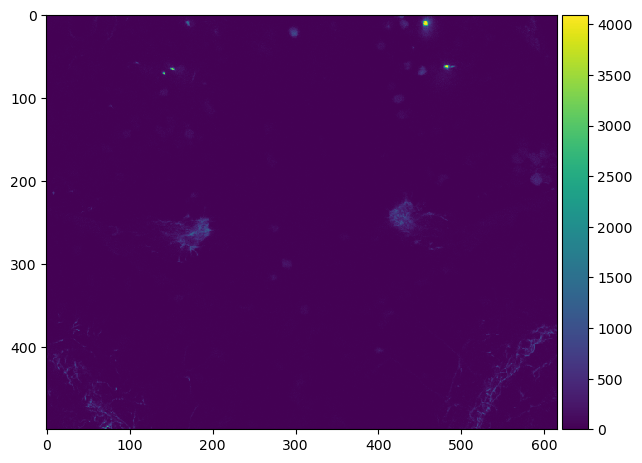

In [7]:
imshow(np_image)

要访问我们3D图像中的所有像素，我们应该首先查看文件的元数据。

In [8]:
lif_image.info

{'dims': Dims(x=616, y=500, z=86, t=1, m=1),
 'display_dims': (1, 2),
 'dims_n': {1: 616, 2: 500, 3: 86},
 'scale_n': {1: 2.1354804344851965,
  2: 2.135480168493237,
  3: 0.9929687300128537},
 'path': 'Experiment_002/',
 'name': 'Series011',
 'channels': 2,
 'scale': (2.1354804344851965, 2.135480168493237, 0.9929687300128537, None),
 'bit_depth': (12, 12),
 'mosaic_position': [],
 'channel_as_second_dim': False,
 'settings': {}}

例如，知道z/y/x顺序的体素大小可能在以后会有用。

In [9]:
voxel_size = lif_image.info['scale'][2::-1]
voxel_size

(0.9929687300128537, 2.135480168493237, 2.1354804344851965)

我们还可以读出3D堆栈有多少个切片。

In [10]:
num_slices = lif_image.info['dims'].z
num_slices

86

这些信息允许我们编写一个便利函数，可以将LIF图像转换为3D numpy图像堆栈。

In [11]:
def lif_to_numpy_stack(lif_image):
    num_slices = lif_image.info['dims'].z
    
    return np.asarray([np.array(lif_image.get_frame(z=z)) for z in range(num_slices)])

In [12]:
image_stack = lif_to_numpy_stack(lif_image)
image_stack.shape

(86, 500, 616)

然后可以使用这个图像堆栈，例如来可视化沿Z轴的最大强度投影。

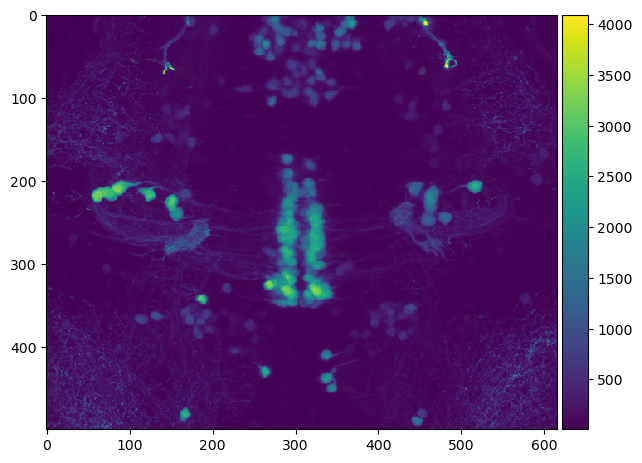

In [13]:
imshow(np.max(image_stack, axis=0))